In [128]:
import numpy as np
import bisect
from scipy.spatial import distance
from scipy.sparse import coo_matrix, csc_matrix
from scipy.sparse.linalg import lsqr
import matplotlib.pyplot as plt

In [232]:
def construct_X(M,alphas,Np=None):
    """ Calculates the weight matrix for a given tomogram size M x M, X-rays under angles alpha and sensor resolution Np
    
    Parameters:
    -----------
    Number of pixel of square tomogram: M (Int)
    List of angles under which CT is performed: alphas (List of Int)
    Resolution of CCD sensor (optional): Np (Int)
    
    
    If Np = None, Np is set as ceiling(sqrt(2)*M)
    
    Returns:
    Np * len(alphas) x M*M matrix with weights of the pixels
    """
    if Np == None: Np = np.ceil(np.sqrt(2)*M)
    a0 = -M/2 + 0.5
    b0 = -M/2 + 0.5
    C = np.mgrid[a0:M+a0,b0:M+b0]
  
    C = C.reshape(2,M*M) # array of (a,b) vectors that belong to the centers of the bins
    
    
    n = np.array([0,1]) # unrotated unit vector
    
    #project tomogram pixel on sensor
    alphas = np.array(alphas)/360 * 2 * np.pi 
    def rot(a):
        return np.array([[np.cos(a),-np.sin(a)],[np.sin(a),np.cos(a)]])
    p = np.dot(np.array([np.dot(rot(i),n)for i in alphas]),C).flatten() # vectorized for all alphas at the same time

    # calculate differences and use boolean slicing to get rid of pixels that do not count
    sensor = np.arange(-Np/2+0.5,Np/2+0.5,1) # sensor bin center coordinates
   
    
    d = np.abs(distance.cdist(sensor.reshape(sensor.shape[0],1),p.reshape(p.shape[0],1)))
    
    d = np.concatenate(np.hsplit(d,len(alphas)),axis=0) # transform matrix from Np x len (alpha)* M*M to Np*len(alpha) x M*M 
    idx = np.where(d<1) # select relevant elements, i.e. where distance of projected tomograph pixels to sensor pixels smaller 1

    X = coo_matrix(((1-d[idx]),idx),shape=(int(Np*len(alphas)),M*M),dtype=np.float32) # save relevant weigths in array. Triangular shape of resulting signal 
                                                                                    # is achieved by 1 - d
    return X

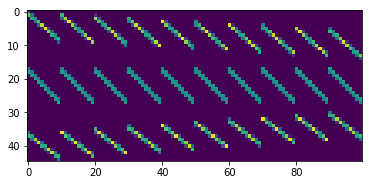

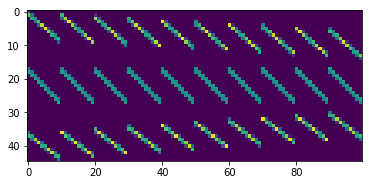

In [236]:
X = construct_X(10,[-33,1,42])
#X = construct_X(2,[0])
#X = construct_X(2,[0,90])
plt.imshow(X.toarray())
X_test = np.load('./hs_tomography/X_example.npy')
plt.show()
plt.imshow(X_test)
plt.show()


In [239]:
alphas = np.load('./hs_tomography/alphas_77.npy')
X_77 = construct_X(77,alphas,109)